# Scaling Simulation Duration, Delay, and Cores

- Scale Duration configs [[ps-config.xml](../experiments/baseline-trinitite/nano/parmsweep/scale-length-hr4-59971/input/ps-config.xml), [input.slurm](../experiments/baseline-trinitite/nano/parmsweep/scale-length-hr4-59971/scale-length/parsplice-hr4)]
- Scale Delay configs [[ps-config.xml](../experiments/baseline-trinitite/nano/parmsweep/scale-delay-100000-60117/input/ps-config.xml), [input.slurm](../experiments/baseline-trinitite/nano/parmsweep/scale-delay-100000-60117/scale-delay/parsplice-d100K)]
- Scale Cores configs [[ps-config.xml](../experiments/baseline-trinitite/nano/parmsweep/scale-tasks-64-59958/input/ps-config.xml), [input.slurm](../experiments/baseline-trinitite/nano/parmsweep/scale-tasks-64-59958/scale-workers/parsplice-t64)]

In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
 if (code_show){$('div.input').hide();}
 else {$('div.input').show();}
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                             

# Scale Along Various Dimensions

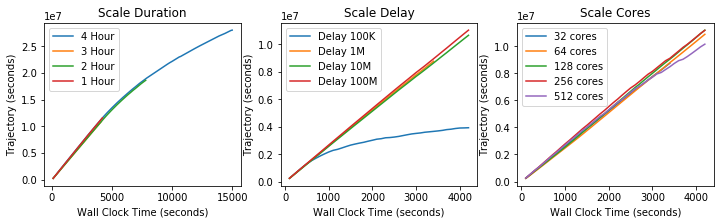

In [2]:
RAW_DF   = 0
COUNT_DF = 1
rank_names = {"00": "Splicer", "01": "Worker", "02": "PersistentDB", "03": "InMemoryDB", "04": "WorkManager", -1: "all ranks"}

def untar(fname):
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()

def plot_times(ax, label, results):
    if os.path.exists(results + "/times.out"):
        df = pd.read_csv(results + "/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    else:
        untar(results + "/times.tar.gz")
        shutil.move("times.out", "tmp/times.out")                
        df = pd.read_csv("tmp/times.out", delimiter=" ", index_col=False, names=["wc", "traj"])
    ax.plot(df["wc"], df["traj"], label=label)
    ax.set_ylabel("Trajectory (seconds)")
    ax.set_xlabel("Wall Clock Time (seconds)")
    ax.legend()

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
d = "../experiments/baseline-trinitite/"
ax[0].set_title("Scale Duration")
plot_times(ax[0], "4 Hour", d+"nano/parmsweep/scale-length-hr4-59971")
plot_times(ax[0], "3 Hour", d+"nano/parmsweep/scale-length-hr3-59970")
plot_times(ax[0], "2 Hour", d+"nano/parmsweep/scale-length-hr2-59969")
plot_times(ax[0], "1 Hour", d+"nano/parmsweep/scale-length-hr1-59968")

ax[1].set_title("Scale Delay")
plot_times(ax[1], "Delay 100K", d+"nano/parmsweep/scale-delay-100000-60117")
plot_times(ax[1], "Delay 1M", d+"nano/parmsweep/scale-delay-1000000-60120")
plot_times(ax[1], "Delay 10M", d+"nano/parmsweep/scale-delay-10000000-60119")
plot_times(ax[1], "Delay 100M", d+"nano/parmsweep/scale-delay-100000000-60118")

ax[2].set_title("Scale Cores")
plot_times(ax[2], "32 cores",  d+"nano/parmsweep/scale-delay-1000000-60120")
plot_times(ax[2], "64 cores",  d+"nano/parmsweep/scale-tasks-64-59958")
plot_times(ax[2], "128 cores", d+"nano/parmsweep/scale-tasks-128-59959")
plot_times(ax[2], "256 cores", d+"nano/parmsweep/scale-tasks-256-59962")
plot_times(ax[2], "512 cores", d+"nano/parmsweep/scale-tasks-512-59963")

In [3]:
names = {"0": "Splicer", "1": "Worker", "2": "PersistentDB",
         "3": "InMemoryDB", "4": "WorkManager", -1: "all ranks"}

### Boring Parsing Info
# The data structure we read into is a dictionary, where the key is a tuple that identifies the job and the 
# value is a tuple with parsed data in Python data frames. The `parse()` function reads the raw data and 
# puts it into the dictionary:
#
# dfs[(name, op, rank)] => {KEY TIMES, KEY COUNT}
#
# where `name` is a human readable string that describes the job, `op` is the type of database operation,
# `rank` is the MPI rank number, `KEY TIMES` has keys and timestamps, and `KEY COUNT` has keys and counts (i.e. # 
# of occurences). We save `countDF` because it takes forever to parse this data.
def parse(dfs, name, results):
    stats = []
    for rank in ["0", "1", "2", "3", "4"]:
        untar(results + "/out/semanticPerf." + rank + ".tar.gz")
        shutil.move("semanticPerf." + rank, "tmp/semanticPerf." + rank)
        for op in ["DBMemoryPut", "DBMemoryGet"]:
            os.system("cat tmp/semanticPerf." + rank + " | grep " + op + " > tmp/keyspace.log")
            df_op = pd.read_csv("tmp/keyspace.log", names=['ts', 'op', 'dbkey', 'key'])
            if len(df_op) == 0: 
                continue           
            dfs[(name, op, rank)] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = {}
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = df_op
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = df_op.groupby('key').size().reset_index()
            dfs[(name, op, rank)]['DF_KEY_COUNT'].columns=['key', 'count']

            # print stats
            stat = dfs[(name, op, rank)]['DF_KEY_COUNT']
            hotK = stat.loc[stat['count'].idxmax()]
            stats.append(name + " " + op + " " + names[rank] + ": nkeys=" + str(len(stat['key']))
                         + ", hottest key=" + str(hotK[0]) + " (count=" + str(hotK[1]) + ")")
            print "...", name, 
    return stats

dfs = {}   # global data structure with parsed data
stats = [] # dumps stats at the end
stats.append(parse(dfs, "4 Hour", d+"nano/parmsweep/scale-length-hr4-59971"))
stats.append(parse(dfs, "3 Hour", d+"nano/parmsweep/scale-length-hr3-59970"))
stats.append(parse(dfs, "2 Hour", d+"nano/parmsweep/scale-length-hr2-59969"))
stats.append(parse(dfs, "1 Hour", d+"nano/parmsweep/scale-length-hr1-59968"))
stats.append(parse(dfs, "Delay 100K", d+"nano/parmsweep/scale-delay-100000-60117"))
stats.append(parse(dfs, "Delay 1M",   d+"nano/parmsweep/scale-delay-1000000-60120"))
stats.append(parse(dfs, "Delay 10M",  d+"nano/parmsweep/scale-delay-10000000-60119"))
stats.append(parse(dfs, "Delay 100M", d+"nano/parmsweep/scale-delay-100000000-60118"))

... 4 Hour ... 4 Hour ... 4 Hour ... 4 Hour ... 4 Hour ... 4 Hour ... 3 Hour ... 3 Hour ... 3 Hour ... 3 Hour ... 3 Hour ... 3 Hour ... 2 Hour ... 2 Hour ... 2 Hour ... 2 Hour ... 2 Hour ... 2 Hour ... 1 Hour ... 1 Hour ... 1 Hour ... 1 Hour ... 1 Hour ... 1 Hour ... Delay 100K ... Delay 100K ... Delay 100K ... Delay 100K ... Delay 100K ... Delay 100K ... Delay 1M ... Delay 1M ... Delay 1M ... Delay 1M ... Delay 1M ... Delay 1M ... Delay 10M ... Delay 10M ... Delay 10M ... Delay 10M ... Delay 10M ... Delay 10M ... Delay 100M ... Delay 100M ... Delay 100M ... Delay 100M ... Delay 100M ... Delay 100M


## Scale duration shows a structured keyspace
- We can predict how big the keyspace will grow
- We can predict how many ops each rank will get
- We can predict when the work manager will spill to in-memory DB

David:
> 

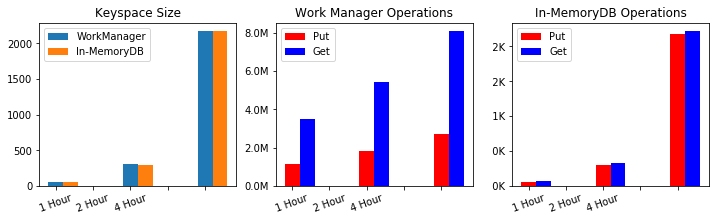

In [4]:
def plot_keyspace(key_names):
    def get_keys(op, rank):
        ret = []
        for name in key_names:
            ret.append((name, op, rank))
        return ret
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    ax[0].set_title("Keyspace Size")
    ax[0].bar(np.arange(len(get_keys("DBMemoryPut", "4"))),
              [len(dfs[k]['DF_KEY_COUNT']) for k in get_keys("DBMemoryPut", "4")],
              label="WorkManager", width=0.2)
    ax[0].bar(np.arange(len(get_keys("DBMemoryPut", "3"))) + 0.2,
              [len(dfs[k]['DF_KEY_COUNT']) for k in get_keys("DBMemoryPut", "3")],
              label="In-MemoryDB", width=0.2)
    
    ax[1].set_title("Work Manager Operations")
    ax[1].bar(np.arange(len(get_keys("DBMemoryPut", "4"))),
              [np.sum(dfs[k]['DF_KEY_COUNT']['count']) for k in get_keys("DBMemoryPut", "4")],
              label="Put", width=0.2, color='red')
    ax[1].bar(np.arange(len(get_keys("DBMemoryGet", "4"))) + 0.2,
              [np.sum(dfs[k]['DF_KEY_COUNT']['count']) for k in get_keys("DBMemoryGet", "4")],
              label="Get", width=0.2, color='blue')
    ax[1].set_yticklabels(['{:3.1f}M'.format(x/1000000) for x in ax[1].get_yticks()])

    ax[2].set_title("In-MemoryDB Operations")
    ax[2].bar(np.arange(len(get_keys("DBMemoryPut", "3"))),
              [np.sum(dfs[k]['DF_KEY_COUNT'])['count'] for k in get_keys("DBMemoryPut", "3")],
              label="Put", width=0.2, color='red')
    ax[2].bar(np.arange(len(get_keys("DBMemoryGet", "3"))) + 0.2,
              [np.sum(dfs[k]['DF_KEY_COUNT'])['count'] for k in get_keys("DBMemoryGet", "3")],
              label="Get", width=0.2, color='blue')
    ax[2].set_yticklabels(['{:3.0f}K'.format(x/1000) for x in ax[2].get_yticks()])

    for a in range(0, len(ax)):
        ax[a].set_xticklabels([0] + [k[0] for k in get_keys("DBMemoryPut", "4")], rotation=20)
        ax[a].legend()

plot_keyspace(["1 Hour", "2 Hour", "4 Hour"])

## Scale delay shows something different for 100K
- bigger keyspace
- colder keys
- not linear

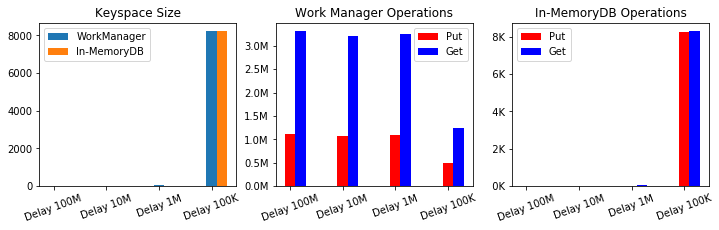

In [5]:
plot_keyspace(["Delay 100M", "Delay 10M", "Delay 1M", "Delay 100K"])

## Scale cores shows ... wtf?

... 64 cores ... 64 cores ... 64 cores ... 64 cores ... 64 cores ... 64 cores ... 128 cores ... 128 cores ... 128 cores ... 128 cores ... 128 cores ... 128 cores ... 256 cores ... 256 cores ... 256 cores ... 256 cores ... 256 cores ... 256 cores ... 512 cores ... 512 cores ... 512 cores ... 512 cores ... 512 cores ... 512 cores


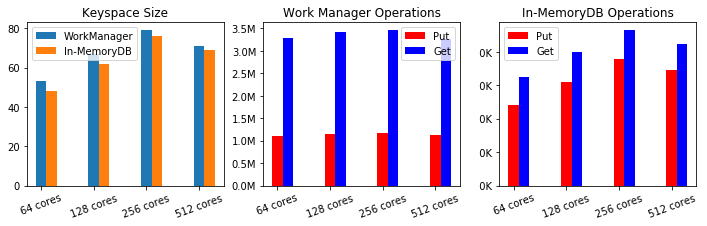

In [6]:
dfs = {}
stats.append(parse(dfs, "64 cores",  d+"nano/parmsweep/scale-tasks-64-59958"))
stats.append(parse(dfs, "128 cores", d+"nano/parmsweep/scale-tasks-128-59959"))
stats.append(parse(dfs, "256 cores", d+"nano/parmsweep/scale-tasks-256-59962"))
stats.append(parse(dfs, "512 cores", d+"nano/parmsweep/scale-tasks-512-59963"))
stats.append(plot_keyspace(["64 cores", "128 cores", "256 cores", "512 cores"]))

In [8]:
parse(dfs, "Delay 1M",   d+"nano/parmsweep/scale-delay-1000000-60120")
parse(dfs, "Delay 100K",   d+"nano/parmsweep/scale-delay-100000-60117")

... Delay 1M ... Delay 1M ... Delay 1M ... Delay 1M ... Delay 1M ... Delay 1M ... Delay 100K ... Delay 100K ... Delay 100K ... Delay 100K ... Delay 100K ... Delay 100K

['Delay 100K DBMemoryPut Splicer: nkeys=71, hottest key=10396159671373412358 (count=1)',
 'Delay 100K DBMemoryGet Splicer: nkeys=71, hottest key=13397889897772269455 (count=2)',
 'Delay 100K DBMemoryPut InMemoryDB: nkeys=8238, hottest key=10000949668668174214 (count=1)',
 'Delay 100K DBMemoryGet InMemoryDB: nkeys=8238, hottest key=10396159671373412358 (count=2)',
 'Delay 100K DBMemoryPut WorkManager: nkeys=8244, hottest key=16222664147866608531 (count=10119)',
 'Delay 100K DBMemoryGet WorkManager: nkeys=8244, hottest key=13397889897772269455 (count=30210)']

In [9]:
def plot_keytimes(ax, dfs, key, shift=0, nkeys=50):
    topKeys = dfs[key]['DF_KEY_COUNT'].nlargest(nkeys, 'count').head(nkeys)
    for k in topKeys['key']:
        raw = dfs[key]['DF_KEY_TIMES']
        df = raw[(raw['key'] ==  k)]
        if len(df) == 0:
            continue
        df = df.groupby('ts').size().reset_index()
        df.columns=['ts', 'count']
        
        first    = np.min(df['ts']) - 1
        ts_range = np.max(df['ts']) - first + 2
        x = np.arange(ts_range) + first
        y = np.zeros(ts_range)
        for k, v in df.iterrows():
            y[v['ts'] - first] = v['count']
        ax.plot(x, y, label=key)
    ax.set_xticklabels([])
    ax.set_title(key[0])
    ax.set_ylabel(key[1] + "/sec")

In [10]:
def plot_keytimes(ax, dfs, key_tuple, shift=0, nkeys=50):
    color = plt.cm.jet(np.linspace(0, 1, nkeys)) # get more colors (equal to number of keys)
    c_idx = np.arange(0, nkeys)                  # create an array of indices
    np.random.shuffle(c_idx)                     # randomly assign colors
    
    # get top n keys
    df = dfs[key_tuple]['DF_KEY_COUNT']          # get the count df for this run
    df = df.nlargest(nkeys, 'count')             # get the keys that show up the most
    df = df.head(nkeys)                          # not sure why we need to do head here

    i = 0
    print key_tuple[0] + " UNIQUE KEYS=" + str(len(df['key'])) + " pulling from " + str(len(dfs[key_tuple]['DF_KEY_COUNT']))
    for key in df['key']:
        
        # group this key's timestamps for this op
        d = dfs[key_tuple]['DF_KEY_TIMES']       # now we need the raw df for this run
        d = d[(d['key'] == key)]                 # focus only on this key
        n = str(len(d))                          # save off the total number of ops
        d = d.groupby('ts').size()             # count the number of ops at each timestamp
        d = d.reset_index()                      # flip the axes
        d.columns = ['ts', 'count']            # label the axes

        # plot df if it's not empty
        if len(d) == 0: continue
        first   = np.min(d['ts'])              # we need to do some timestamp finnagling
        last    = np.max(d['ts'])
        tsrange = last - first + 1
        x = np.arange(tsrange + 2) + first       # x axis is shifted by real time (+2 so NULL plot to 0)
        y = np.zeros(tsrange + 2)                # y axis starts as array of zeros...
        for k, v in d.iterrows():                # ... but is filled in w/ counts for that ts
            idx    = v['ts'] - first + 1       # overwrite value (shifted to account for ts and initial 0)
            y[idx] = v['count']
        ax.plot(x, y, color=color[c_idx[0]], label=n)
        c_idx = np.delete(c_idx, 0)              # get a unique color but don't use it again

    # cleanup graphs
    ax.set_title(key_tuple[0] + " (Legend = total #ops)", fontsize=14)
    ax.set_ylabel(key_tuple[1] + "/sec")
    
def plot_uniquekeys_per_ts(ax, dfs, key_tuple, ylim=800, shift=0, nkeys=50):
    df = dfs[key_tuple]['DF_KEY_TIMES']           # get all timestamps for all keys
    df = df.drop_duplicates()                    # only find unique keys by dropping duplicates
    df = df.groupby('ts').size()               # for each time stamp, count the unique
    df = df.reset_index()
    df.columns=['ts', 'count']
    ax.plot(df['ts'], df['count'], color='black', label="unique keys")

    # cleanup graphs
    ax.set_title(key_tuple[0] + " (Legend = total #ops)", fontsize=14)
    ax.set_ylabel("Unique Keys")
    ax.legend()

## Keyspace behavior shows workload regimes
- unique keys increase over time
- throughput of keys goes down
- can we learn them?

Delay 100K UNIQUE KEYS=200 pulling from 8244


(-50, 100)

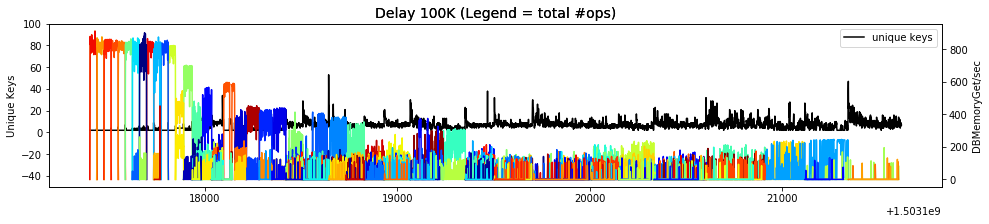

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
plot_uniquekeys_per_ts(ax, dfs, ("Delay 100K", "DBMemoryGet", "4"), nkeys=200)
plot_keytimes(ax.twinx(), dfs, ("Delay 100K",   "DBMemoryGet", "4"), nkeys=200)
ax.set_ylim(-50, 100)

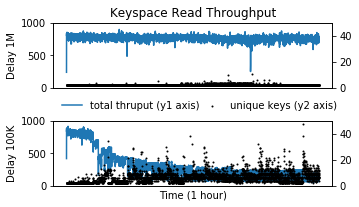

In [12]:
def plot_uniquekeys_per_ts(ax, dfs, key_tuple, ylim=800, shift=0):
    df = dfs[key_tuple]['DF_KEY_TIMES']            # get all timestamps for all keys
    
    df_t = df.groupby('ts').size().reset_index()   # throughput
    df_t.columns=['ts', 'count']
    
    df_u = df.drop_duplicates()                    # only find unique keys by dropping duplicates
    df_u = df_u.groupby('ts').size().reset_index() # for each time stamp, count the unique
    df_u.columns=['ts', 'count']
    
    ax.plot(df_t['ts'], df_t['count'], label="total thruput (y1 axis)")
    ax2 = ax.twinx()
    ax2.scatter(df_u['ts'], df_u['count'], color='black', s=1, label="unique keys (y2 axis)")
    ax.set_ylim(0, 2000)
    ax2.set_ylim(0, 50)
    return ax2

fig, ax = plt.subplots(2, 1, figsize=(5, 3))
fig.subplots_adjust(hspace=.5)
plot_uniquekeys_per_ts(ax[0], dfs, ("Delay 1M", "DBMemoryGet", "4"))
ax2 = plot_uniquekeys_per_ts(ax[1], dfs, ("Delay 100K", "DBMemoryGet", "4"))
ax[0].set_xlabel("")
for i in range(0, len(ax)):
    ax[i].set_xticklabels([])
    ax[i].set_xticks([])
    ax[i].set_ylim(0, 1000)
ax[1].set_xlabel("Time (1 hour)")
ax[1].legend(bbox_to_anchor=(0, 1.45), loc='upper left', frameon=False)
ax2.legend(bbox_to_anchor=(0.5, 1.45), loc='upper left', frameon=False)
ax[0].set_title("Keyspace Read Throughput")
ax[0].set_ylabel("Delay 1M")
ax[1].set_ylabel("Delay 100K")
plt.savefig("../paper/figures/keyspace-regimes.png", dpi=400, bbox_inches='tight')

In [14]:
stats

[['4 Hour DBMemoryPut Splicer: nkeys=51, hottest key=10313986423432176915 (count=1)',
  '4 Hour DBMemoryGet Splicer: nkeys=51, hottest key=13397889897772269455 (count=2)',
  '4 Hour DBMemoryPut InMemoryDB: nkeys=2173, hottest key=10002327738147764502 (count=1)',
  '4 Hour DBMemoryGet InMemoryDB: nkeys=2173, hottest key=10313986423432176915 (count=2)',
  '4 Hour DBMemoryPut WorkManager: nkeys=2178, hottest key=14045287823504495930 (count=100092)',
  '4 Hour DBMemoryGet WorkManager: nkeys=2193, hottest key=14045287823504495930 (count=300219)'],
 ['3 Hour DBMemoryPut Splicer: nkeys=16, hottest key=11669211761296708093 (count=1)',
  '3 Hour DBMemoryGet Splicer: nkeys=16, hottest key=13397889897772269455 (count=2)',
  '3 Hour DBMemoryPut InMemoryDB: nkeys=46, hottest key=10709269897150474038 (count=1)',
  '3 Hour DBMemoryGet InMemoryDB: nkeys=46, hottest key=11669211761296708093 (count=2)',
  '3 Hour DBMemoryPut WorkManager: nkeys=56, hottest key=1736974060065875077 (count=1922214)',
  '3 H